# Water conservation example

In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

The purpose of this notebook is to demonstrate water conservation for the ML model.  Water conservation can be summarized as follows

$\sum_i \left( \delta q_v + \delta q_l + \delta q_i \right) \frac{\Delta p_i}{g \delta t} = E - P$

$q_v$ is `state_q0001`, $q_l$ is `state_q0002`, $q_i$ is `state_q0003`, $E$ is `pbuf_LHFLX`/$L_v$, and $P$ is `cam_out_PRECC`

In [2]:
datadir = '/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne30/train/0001-02/'
mli     = xr.open_dataset(datadir + 'E3SM-MMF.mli.0001-02-14-72000.nc')
mlo     = xr.open_dataset(datadir + 'E3SM-MMF.mlo.0001-02-14-72000.nc')

Begin with column-integrated water values for inputs and outputs.  We need to construct the pressure thickness $\Delta p_i$ from the interface pressures.

$P = A_k P_o + B_k P_s$

$A_k$ and $B_k$ come from the initial condition file.  We will load that in here to extract the interface pressure coefficients.  Note that it is assumed that the pressure levels are fixed during the physics parameterizations, so we will only compute pressure thicknesses once.

In [3]:
initial_conditions = '/global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/' + 'eam_i_mam3_Linoz_ne30np4_L60_c20210917.nc'
with xr.open_dataset(initial_conditions) as inic:
    iface = dict()
    iface['hyai'] = inic['hyai']
    iface['hybi'] = inic['hybi']
    iface['P0']   = inic['P0']

In [4]:
def get_pressure_thickness(PS, iface, coords):
    def getPINT(hyai, hybi, P0, PS):
        PINT = P0 * hyai + PS * hybi
        PINT.attrs.update({'units': 'Pa',
                           'long_name': 'Pressure at interface levels'})
        return PINT
    PINT    = getPINT(iface['hyai'], iface['hybi'], iface['P0'], PS)
    dP_temp = PINT.diff('ilev', n=1)
    dP_temp = dP_temp.rename({'ilev': 'lev'})
    dP_temp = dP_temp.transpose(*coords.dims)
    dP = xr.DataArray(dP_temp.values, coords=coords, dims=coords.dims,
                      attrs={'units': 'Pa', 
                             'long_name': 'Pressure thickness of each level'})
    return dP

In [5]:
dP = get_pressure_thickness(mli['state_ps'], iface, mli['state_pmid'].coords)

In [6]:
igrav = 1. / 9.80616 # hard-coded constant for E3SM
for var in ['state_q0001', 'state_q0002', 'state_q0003']:
    mli['CI_' + var] = (mli[var] * dP * igrav).sum('lev')
    mlo['CI_' + var] = (mlo[var] * dP * igrav).sum('lev')
    
mli['total_water'] = mli['CI_state_q0001'] + mli['CI_state_q0002'] + mli['CI_state_q0003']
mlo['total_water'] = mlo['CI_state_q0001'] + mlo['CI_state_q0002'] + mlo['CI_state_q0003']

Next we need the surface fluxes of water into (evapotranspiration, $E$) and out of the column (precipitation, $P$)

In [7]:
surface_water_flux = -1e3 * (mlo['cam_out_PRECC']) # convert from m/s to kg/m2/s with factor of 1000; positive values into atmosphere

In [8]:
mlo['expected_water']  = mli['total_water'] + (1200. * surface_water_flux) # time step is 1200 seconds
mlo['water_error']     = (mlo['expected_water'] - mlo['total_water'])
mlo['water_error_rel'] = mlo['water_error'] / mlo['total_water']

Check the relative errors for the various columns and make a map plot to look for geographical patterns.  Errors are within a few percent.

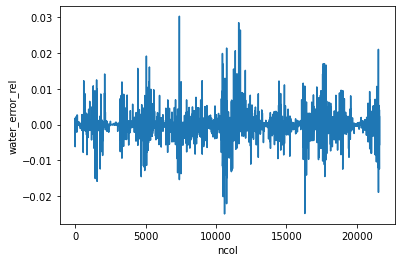

In [9]:
mlo['water_error_rel'].plot()

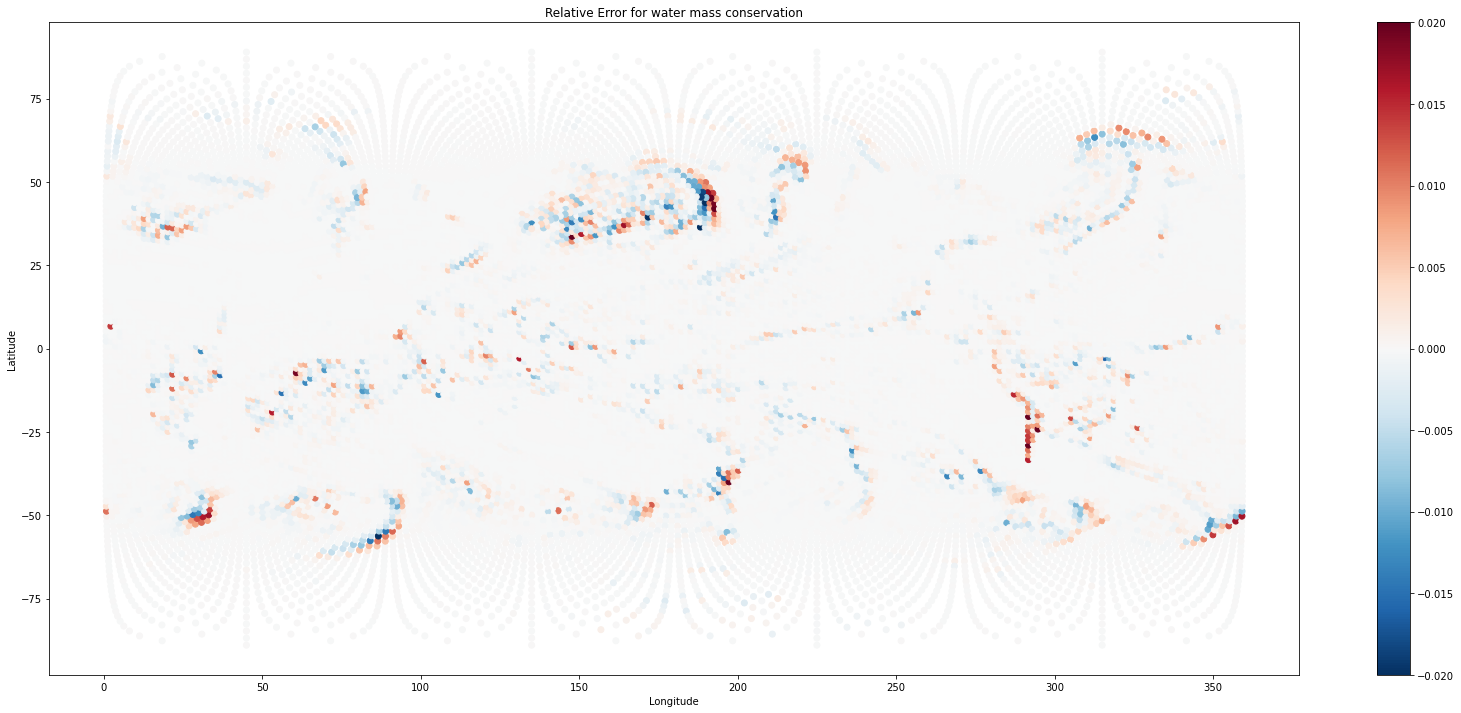

In [28]:
plt.figure(figsize=(28,12))
plt.scatter(inic['lon'], inic['lat'], c=mlo['water_error_rel'], vmin=-0.02, vmax=0.02, cmap='RdBu_r')
plt.xlabel('Longitude'), plt.ylabel('Latitude'), plt.title('Relative Error for water mass conservation')
plt.colorbar()